# **1. Importowanie potrzebnych bibliotek**


In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter

# Ustawienie stylu wykresów
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)

# **2. Wczytanie danych**

In [57]:
# Wczytanie zbioru danych z pliku CSV
df = pd.read_csv('cards_metadata.csv')

# Wyświetlenie przykładowych wierszy
print(df.sample(10))

                                     image_paths  cmc collector_number  \
13622           cards\Jack-o-Lantern\mid_254.jpg  1.0              254   
84718          cards\Dream Twist\plst_EMA-47.jpg  1.0           EMA-47   
46412                    cards\Plains\ddp_37.jpg  0.0               37   
26049         cards\Stormfront Riders\tsr_46.jpg  5.0               46   
32357  cards\Narset Parter of Veils\pwar_61s.jpg  3.0              61s   
41201      cards\Retriever Phoenix\prm_90094.jpg  4.0            90094   
83005    cards\Corrupt Court Official\ptk_71.jpg  2.0               71   
17088       cards\Goblin Assault\plst_MM3-95.jpg  3.0           MM3-95   
30643  cards\Delayed Blast Fireball\sld_1824.jpg  3.0             1824   
48658        cards\Endoskeleton\plst_USG-294.jpg  2.0          USG-294   

       num_colors colors  year  num_types  text_length color_identity  \
13622           0    NaN  2021          1           28            NaN   
84718           1      U  2019         

# **3. Wstępna eksploracja danych**

In [58]:
# Sprawdzenie brakujących wartości w kolumnach
print("\nBrakujące wartości w każdej kolumnie:")
print(df.isnull().sum())

# Wyświetlenie statystyk opisowych
print("\nStatystyki opisowe:")
print(df.describe())


Brakujące wartości w każdej kolumnie:
image_paths             0
cmc                     0
collector_number        0
num_colors              0
colors              22451
year                    0
num_types               0
text_length             0
color_identity      11675
rarity                  0
supertypes          79101
types                 591
subtypes            37488
dtype: int64

Statystyki opisowe:
                  cmc    num_colors          year     num_types   text_length
count    97979.000000  97979.000000  97979.000000  97979.000000  97979.000000
mean        23.316940      0.922279   2015.565805      1.249849     24.354464
std       4517.987883      0.666907      8.852799      0.475530     16.937511
min          0.000000      0.000000   1993.000000      1.000000      0.000000
25%          2.000000      1.000000   2011.000000      1.000000     11.000000
50%          3.000000      1.000000   2019.000000      1.000000     22.000000
75%          4.000000      1.000000   2022.

# **4. Przetwarzanie danych**

# 4.1. Usunięcie kart z 'cmc' > 20

In [59]:
df = df[df['cmc'] <= 20]

# 4.2. Przetwarzanie kolumny 'image_paths' do 'image_path'


In [60]:
df['image_path'] = df['image_paths'].apply(lambda x: x.split(';')[0] if pd.notnull(x) else '')

# Usunięcie wierszy z pustymi ścieżkami do obrazów
df = df[df['image_path'] != '']

# Sprawdzenie istnienia plików obrazów i usunięcie wierszy bez obrazów
df['image_exists'] = df['image_path'].apply(lambda x: os.path.exists(x))
df = df[df['image_exists']]
df.drop('image_exists', axis=1, inplace=True)

# Usunięcie wierszy z brakującymi wartościami w kluczowych kolumnach
df.dropna(subset=['cmc', 'year', 'rarity'], inplace=True)

# 4.3. Konwersja kolumn 'colors' i 'color_identity' do list, obsługa wartości NaN

In [61]:
def convert_colors_to_list(x):
    if pd.isnull(x) or x == '':
        return ['C']  # Dla bezkolorowych kart
    else:
        return x.split(',')

df['colors'] = df['colors'].apply(convert_colors_to_list)
df['color_identity'] = df['color_identity'].apply(convert_colors_to_list)

# 4.4. Obliczenie 'num_colors'

In [62]:
df['num_colors'] = df['colors'].apply(len)

# 4.5. Konwersja kolumn 'supertypes' i 'types' do list, usunięcie 'subtypes'


In [63]:
def convert_to_list(x):
    if pd.isnull(x) or x == '':
        return []
    else:
        return x.split(',')

df['supertypes'] = df['supertypes'].apply(convert_to_list)
df['types'] = df['types'].apply(convert_to_list)

# Usunięcie kolumny 'subtypes'
df.drop('subtypes', axis=1, inplace=True)

# 4.6. One-hot encoding dla 'supertypes' i 'types'

In [64]:
# One-hot encoding dla 'supertypes'
supertypes_set = set()
for st_list in df['supertypes']:
    supertypes_set.update(st_list)

for supertype in supertypes_set:
    if supertype != '':
        df[f'supertype_{supertype}'] = df['supertypes'].apply(lambda x: 1 if supertype in x else 0)

# One-hot encoding dla 'types'
types_set = set()
for t_list in df['types']:
    types_set.update(t_list)

for typ in types_set:
    if typ != '':
        df[f'type_{typ}'] = df['types'].apply(lambda x: 1 if typ in x else 0)

# 4.7. Generowanie kodów dla 'colors' i 'color_identity'


In [65]:
def get_code(colors_list):
    sorted_colors = sorted(colors_list)
    code = ''.join(sorted_colors)
    return code

df['colors_code'] = df['colors'].apply(get_code)
df['color_identity_code'] = df['color_identity'].apply(get_code)

# 4.8. Tworzenie mapowań i kodowanie 'colors_code' i 'color_identity_code'

In [66]:
def create_mapping_and_encode(column_name):
    unique_codes = df[column_name].unique()
    code_mapping = {code: idx for idx, code in enumerate(unique_codes)}
    # Zapisanie mapowania do pliku
    mapping_filename = f'{column_name}_mapping.txt'
    with open(mapping_filename, 'w') as f:
        for code, idx in code_mapping.items():
            f.write(f'{idx}: {code}\n')
    # Kodowanie wartości w DataFrame
    df[f'{column_name}_encoded'] = df[column_name].map(code_mapping)
    return code_mapping

# Tworzenie mapowań i kodowanie
colors_code_mapping = create_mapping_and_encode('colors_code')
color_identity_code_mapping = create_mapping_and_encode('color_identity_code')

# 4.9. Konwersja 'cmc' i 'num_colors' do typu całkowitego

In [67]:
df['cmc'] = df['cmc'].astype(int)
df['num_colors'] = df['num_colors'].astype(int)

# 4.10. Mapowanie 'rarity' na wartości numeryczne


In [68]:
rarity_mapping = {'common': 0, 'uncommon': 1, 'rare': 2, 'mythic': 3, 'special': 4, 'bonus': 5}
df['rarity_numeric'] = df['rarity'].map(rarity_mapping)

# **5. Eksploracja i wizualizacja danych**


# 5.1. Histogram 'cmc'


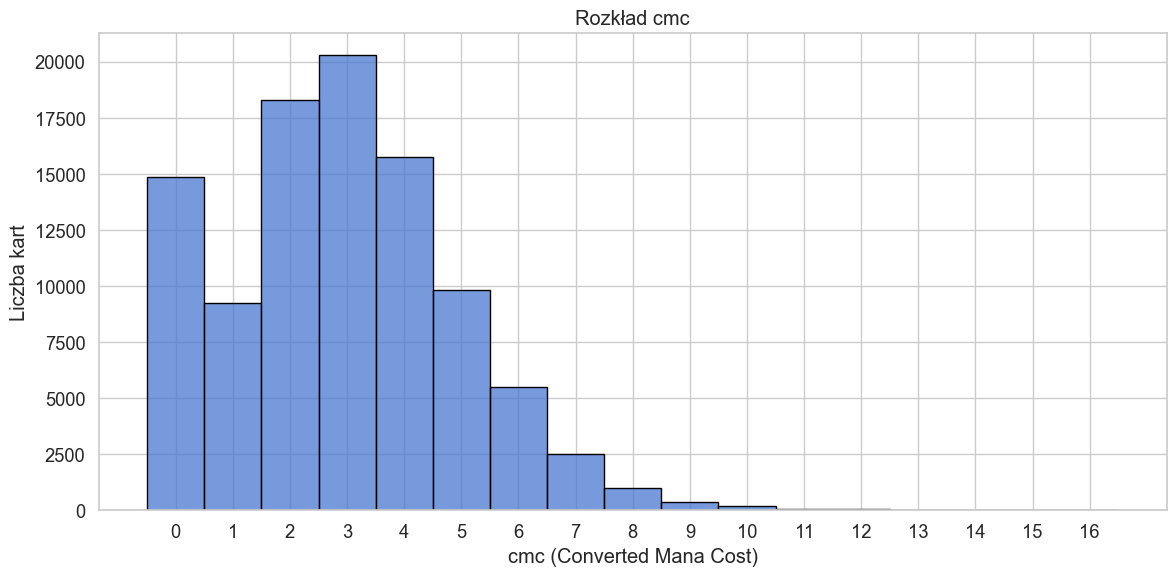

In [69]:
min_cmc = df['cmc'].min()
max_cmc = df['cmc'].max()
bins = np.arange(min_cmc - 0.5, max_cmc + 1.5, 1)

plt.figure(figsize=(12, 6))
sns.histplot(df['cmc'], bins=bins, kde=False, edgecolor='black')
plt.title('Rozkład cmc')
plt.xlabel('cmc (Converted Mana Cost)')
plt.ylabel('Liczba kart')
plt.xticks(np.arange(min_cmc, max_cmc + 1, 1))
plt.tight_layout()
plt.show()

# 5.2. Wykres słupkowy 'num_colors'


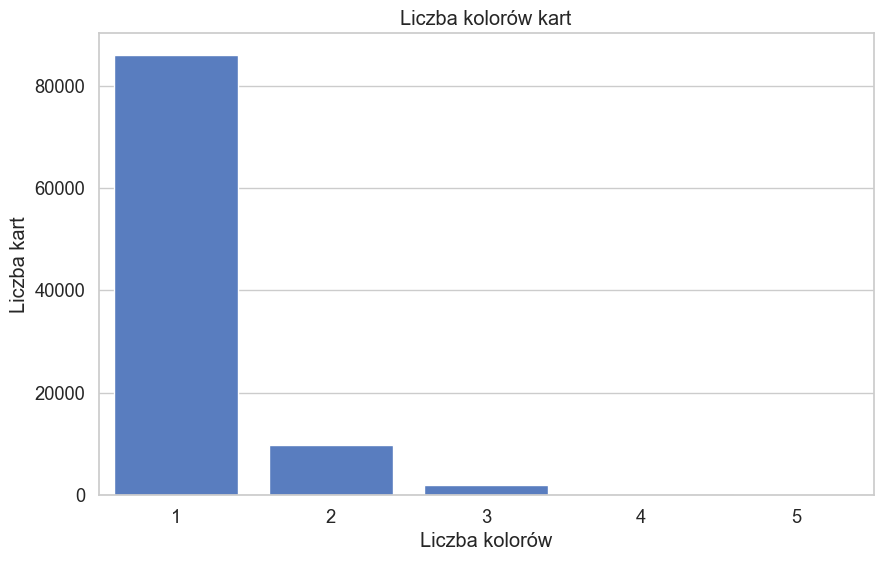

In [70]:
plt.figure(figsize=(10, 6))
sns.countplot(x='num_colors', data=df)
plt.title('Liczba kolorów kart')
plt.xlabel('Liczba kolorów')
plt.ylabel('Liczba kart')
plt.show()

# 5.3. Wykres słupkowy 'year'


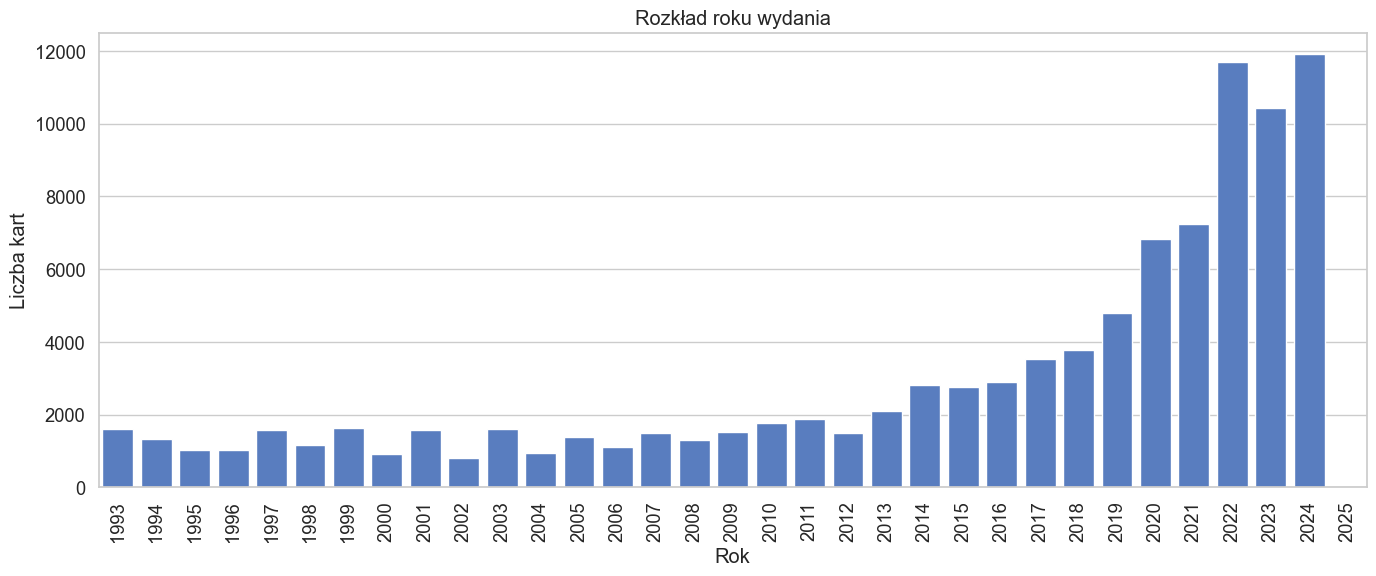

In [71]:
plt.figure(figsize=(14, 6))
sns.countplot(x='year', data=df)
plt.xticks(rotation=90)
plt.title('Rozkład roku wydania')
plt.xlabel('Rok')
plt.ylabel('Liczba kart')
plt.tight_layout()
plt.show()

# 5.4. Wykres słupkowy kombinacji kolorów w 'color_identity_code'


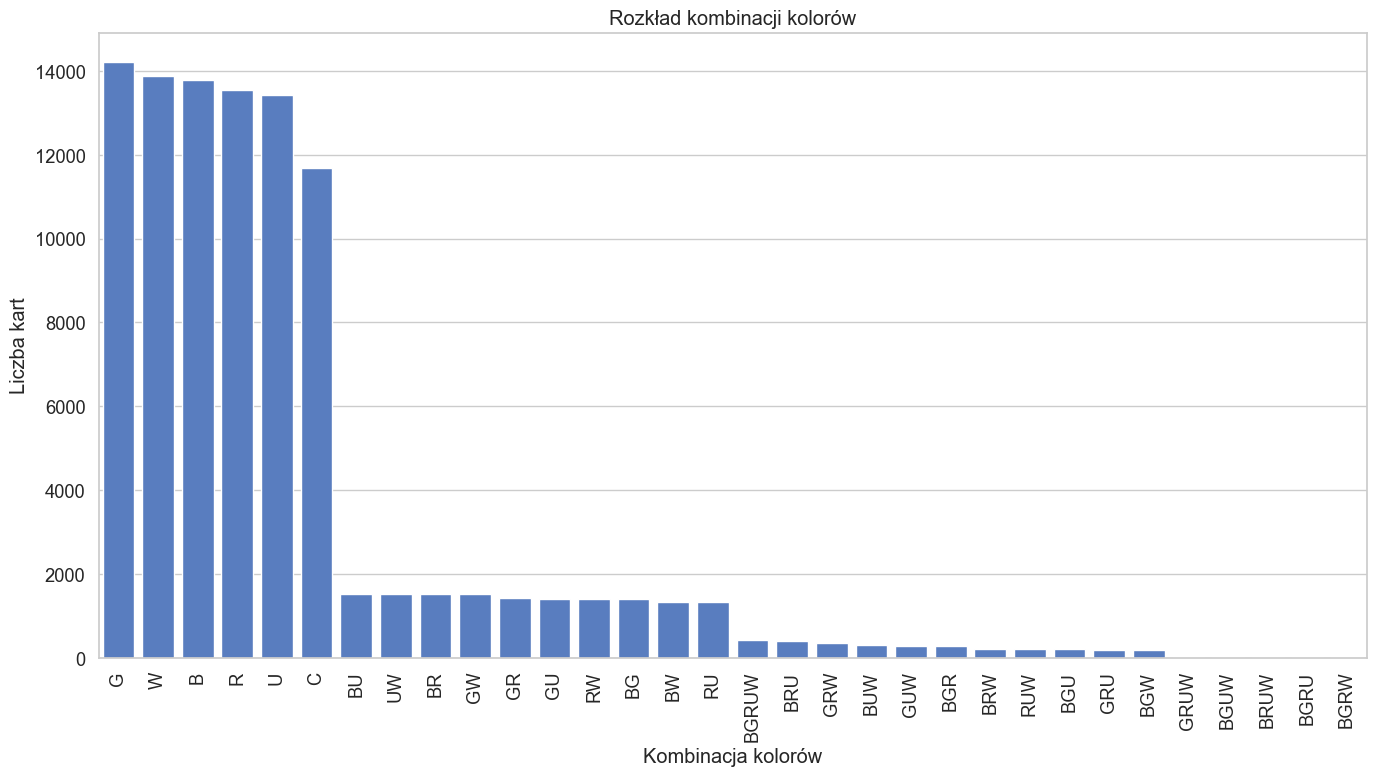

In [72]:

color_combination_counts = df['color_identity_code'].value_counts()

plt.figure(figsize=(14, 8))
sns.barplot(x=color_combination_counts.index, y=color_combination_counts.values)
plt.title('Rozkład kombinacji kolorów')
plt.xlabel('Kombinacja kolorów')
plt.ylabel('Liczba kart')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# 5.5. Wykres słupkowy 'supertypes'


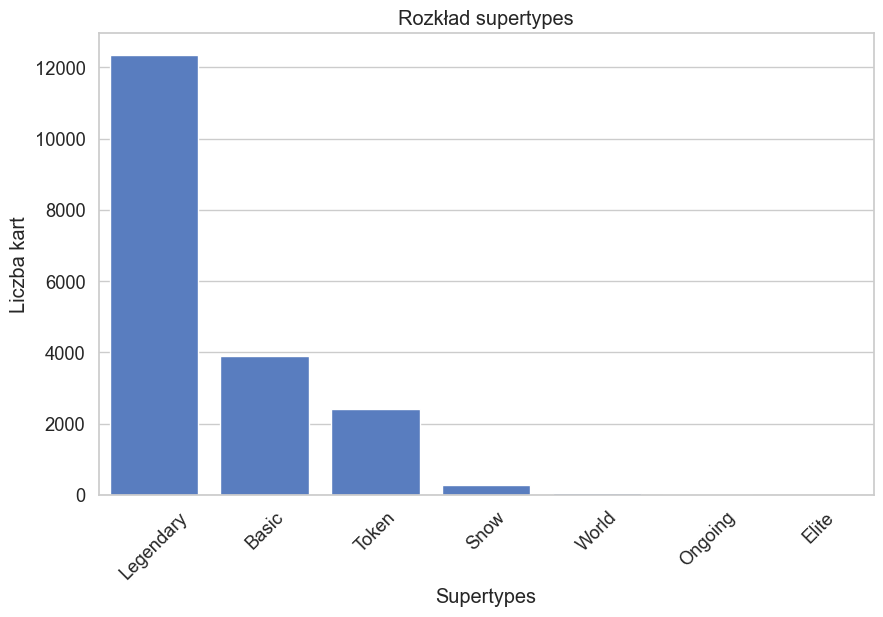

In [73]:
supertype_columns = [col for col in df.columns if col.startswith('supertype_')]
supertype_counts = df[supertype_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=supertype_counts.index.str.replace('supertype_', ''), y=supertype_counts.values)
plt.title('Rozkład supertypes')
plt.xlabel('Supertypes')
plt.ylabel('Liczba kart')
plt.xticks(rotation=45)
plt.show()

# 5.6. Wykres słupkowy 'types'


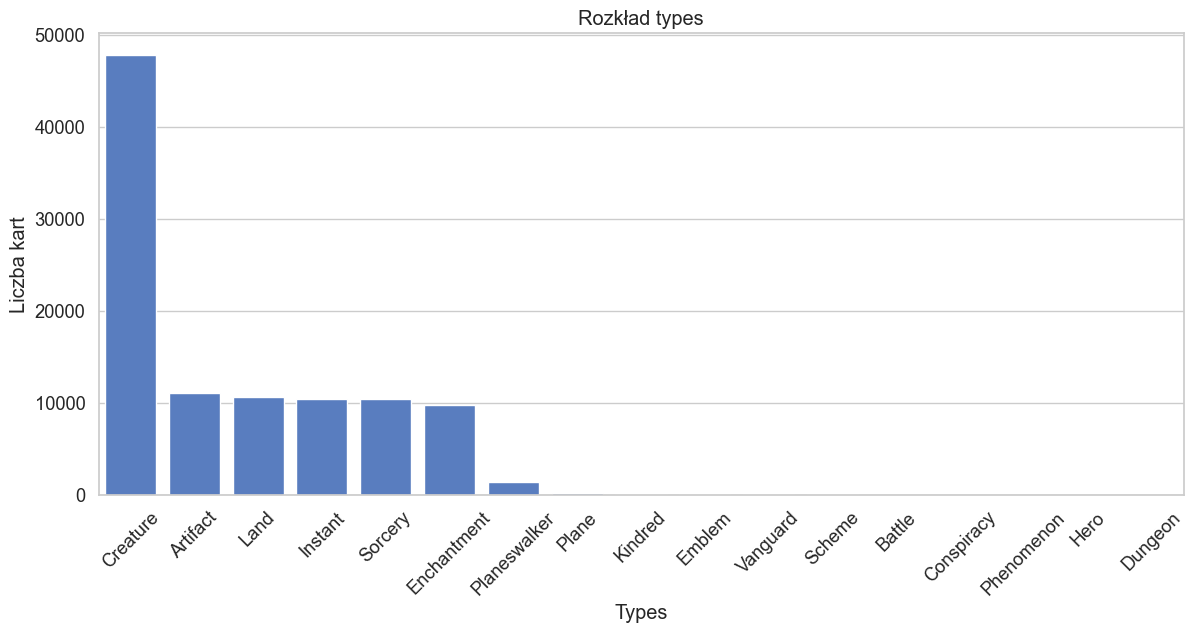

In [74]:
type_columns = [col for col in df.columns if col.startswith('type_')]
type_counts = df[type_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=type_counts.index.str.replace('type_', ''), y=type_counts.values)
plt.title('Rozkład types')
plt.xlabel('Types')
plt.ylabel('Liczba kart')
plt.xticks(rotation=45)
plt.show()

# 5.7. Wykres słupkowy 'rarity'


C:\Users\jakub\AppData\Local\Temp\ipykernel_31408\4292469159.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rarity_counts.index, y=rarity_counts.values, palette='viridis')


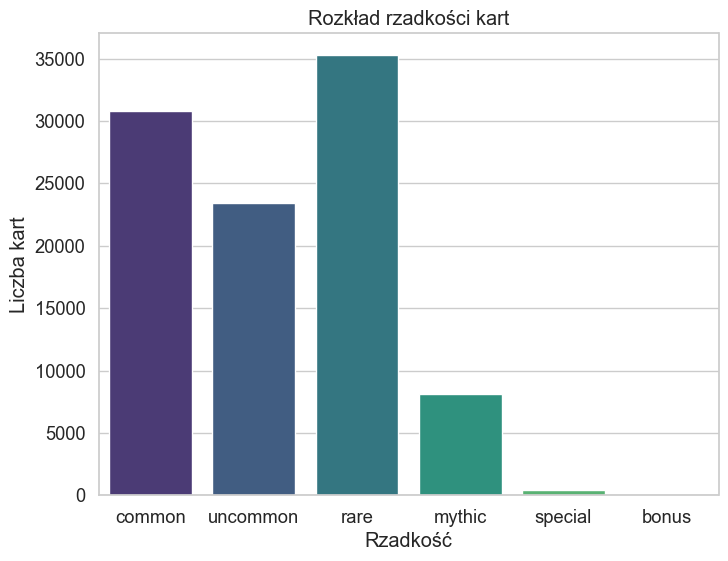

In [75]:
rarity_counts = df['rarity'].value_counts()
rarity_order = ['common', 'uncommon', 'rare', 'mythic', 'special', 'bonus']
rarity_counts = rarity_counts.reindex(rarity_order)

plt.figure(figsize=(8, 6))
sns.barplot(x=rarity_counts.index, y=rarity_counts.values, palette='viridis')
plt.title('Rozkład rzadkości kart')
plt.xlabel('Rzadkość')
plt.ylabel('Liczba kart')
plt.show()

# **6. Podział danych na zbiory treningowe i testowe**


In [76]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['rarity_numeric'])

print(f"Liczba kart w zbiorze treningowym: {len(train_df)}")
print(f"Liczba kart w zbiorze do doszkalania: {len(test_df)}")

Liczba kart w zbiorze treningowym: 68583
Liczba kart w zbiorze do doszkalania: 29394


# **7. Wyświetlenie przykładowego obrazu karty**

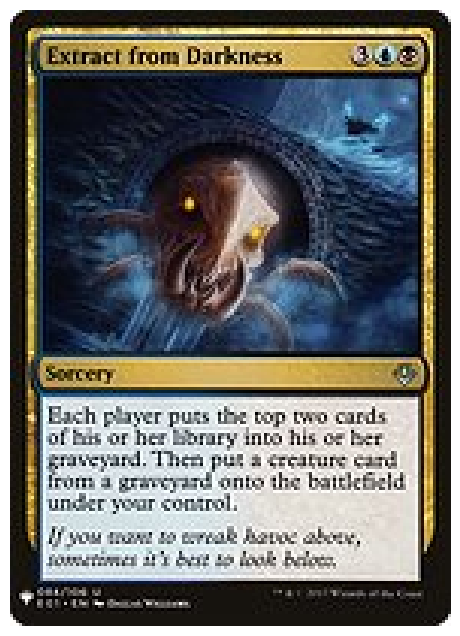

In [77]:
sample_image_path = train_df.iloc[1]['image_path']
image = Image.open(sample_image_path)
plt.figure(figsize=(6, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

# **8. Zapisanie przetworzonych danych**

## 8.1 Usunięcie niepotrzebnych kolumn ##


In [78]:
columns_to_drop = ['image_paths', 'colors', 'color_identity', 'colors_code', 'color_identity_code',
                   'supertypes', 'types']
df.drop(columns=columns_to_drop, inplace=True)

## 8.2 Zapis plików ##

In [ ]:
datasets_dir = 'datasets'

if not os.path.exists(datasets_dir):
    os.makedirs(datasets_dir)


df.to_csv(os.path.join(datasets_dir,'processed_data.csv'), index=False)
train_df.to_csv(os.path.join(datasets_dir,'train_data.csv'), index=False)
test_df.to_csv(os.path.join(datasets_dir,'test_df.csv'), index=False)